# Build a reverse image search engine with Amazon Rekognition, Amazon OpenSearch Service, and Amazon Titan Multimodal Embeddings in Amazon Bedrock

This guide outlines how to build a reverse image search engine using the Amazon Titan Multimodal Embedding Model. It details the steps to embed images as vectors using Amazon Bedrock, store these embeddings in an Amazon OpenSearch Service Serverless vector index, and use Amazon Rekognition to extract key objects from images for querying the index.

## Step 1: Install necessary packages

To retrieve images from our S3 bucket, utilize the Titan Multimodal Embeddings Model, and ingest embeddings into the Amazon OpenSearch index, we will need to install various Python packages

In [1]:
!pip install boto3 pandas opensearch-py requests-aws4auth Pillow sagemaker ipywidgets python-dotenv

## Step 2: Create vector embeddings of images

Once the images are loaded into the S3 bucket, we can then create embeddings for each image file

### 2.1 Create function to handle embedding generation

In [2]:
# Import required libraries
import boto3
import pandas as pd
import base64
import json
from PIL import Image
import io
from dotenv import load_dotenv
import os

load_dotenv()


# Constants, change to your S3 bucket name and selected AWS region
BUCKET_NAME = os.getenv("BUCKET_NAME")
BEDROCK_MODEL_ID = "amazon.titan-embed-image-v1"
REGION = "us-west-2"
# Define max width and height for resizing to accomodate Bedrock limits
MAX_WIDTH = 1024  
MAX_HEIGHT = 1024  

# Initialize AWS clients
s3 = boto3.client('s3')
bedrock_client = boto3.client(
    "bedrock-runtime", 
    REGION, 
    endpoint_url=f"https://bedrock-runtime.{REGION}.amazonaws.com"
)

# Function to resize image
def resize_image(image_data):
    image = Image.open(io.BytesIO(image_data))

    # Resize image while maintaining aspect ratio
    image.thumbnail((MAX_WIDTH, MAX_HEIGHT))

    # Save resized image to bytes buffer
    buffer = io.BytesIO()
    image.save(buffer, format="JPEG")
    buffer.seek(0)

    return buffer.read()

# Function to create embedding from input image
def create_image_embedding(image):
    image_input = {}

    if image is not None:
        image_input["inputImage"] = image
    else:
        raise ValueError("Image input is required")

    image_body = json.dumps(image_input)

    # Invoke Amazon Bedrock with encoded image body
    bedrock_response = bedrock_client.invoke_model(
        body=image_body,
        modelId=BEDROCK_MODEL_ID,
        accept="application/json",
        contentType="application/json"
    )

    # Retrieve body in JSON response
    final_response = json.loads(bedrock_response.get("body").read())

    embedding_error = final_response.get("message")

    if embedding_error is not None:
        print (f"Error creating embeddings: {embedding_error}")

    # Return embedding value
    return final_response.get("embedding")

### 2.2 Loop through S3 bucket and embed images

In [3]:
# Retrieve images stored in S3 bucket 
response = s3.list_objects_v2(Bucket=BUCKET_NAME)
contents = response.get('Contents', [])

# Define arrays to hold embeddings and image file key names
image_embeddings = []
image_file_names = []

# Loop through S3 bucket to encode each image, generate its embedding, and append to array
for obj in contents:
    image_data = s3.get_object(Bucket=BUCKET_NAME, Key=obj['Key'])['Body'].read()

    # Resize the image to meet model requirements
    resized_image = resize_image(image_data)

    # Create base64 encoded image for Titan Multimodal Embeddings model input
    base64_encoded_image = base64.b64encode(resized_image).decode('utf-8')

    # Generate the embedding for the resized image
    image_embedding = create_image_embedding(image=base64_encoded_image)
    image_embeddings.append(image_embedding)
    image_file_names.append(obj["Key"])

### 2.3 Create dataframe to store embeddings and key of image

In [4]:
# Add and list embeddings with associated image file key to dataframe object
final_embeddings_dataset = pd.DataFrame({'image_key': image_file_names, 'image_embedding': image_embeddings})
final_embeddings_dataset.head()

image_key                                    image_embedding
0    image1.jpeg  [0.009804389, 0.0018702685, -0.0020096675, -0....
1   image10.jpeg  [0.008832219, -0.0010021172, -0.015037419, 0.0...
2  image100.jpeg  [0.006052684, 0.012719409, -0.005745664, -0.04...
3   image101.jpg  [0.064759746, 0.021797623, -0.029666476, 3.135...
4  image102.jpeg  [0.0133931665, -0.010198065, -0.004530042, -0....

## 3. Ingest embeddings into OpenSearch Index

With all the embeddings now generated, we can send them to the OpenSearch Serverless vector index

### 3.1 Get SageMaker role to update IAM policy

In [5]:
# If necessary, print SageMaker execution role to update IAM policy for read/write permissions to OpenSearch collection
from sagemaker import get_execution_role
role = get_execution_role()
print(role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
arn:aws:iam::054670858840:role/service-role/AmazonSageMaker-ExecutionRole-20250528T082327


### 3.2 Connect to OpenSearch Collection

In [6]:
# Import required libraries to connect to Amazon OpenSearch Serverless connection
from opensearchpy import OpenSearch, RequestsHttpConnection
from requests_aws4auth import AWS4Auth

# Initialize endpoint name constant
HOST = os.getenv('OPENSEARCH_HOST')

# Initialize and authenticate with the OpenSearch client
credentials = boto3.Session().get_credentials()
auth = AWS4Auth(credentials.access_key, credentials.secret_key, REGION, 'aoss', session_token=credentials.token)
client = OpenSearch(
    hosts=[{'host': HOST, 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=300
)

# Print client connection
print(client)

<OpenSearch([{'host': '0jnmvs3kul6fjrhdq4kh.us-west-2.aoss.amazonaws.com', 'port': 443}])>


### 3.3 Ingest embeddings and key to images

In [7]:
# Import required library to iterate through dataset
import tqdm.notebook as tq

# Your vector index and mapping fields 
INDEX_NAME = os.getenv("INDEX_NAME")
VECTOR_NAME = os.getenv("VECTOR_NAME")
VECTOR_MAPPING = os.getenv("VECTOR_MAPPING") 

# Ingest embeddings into vector index with associate vector and text mapping fields
for idx, record in tq.tqdm(final_embeddings_dataset.iterrows(), total=len(final_embeddings_dataset)):
    body = {
        VECTOR_NAME: record['image_embedding'],
        VECTOR_MAPPING: record['image_key']
    }
    response = client.index(index=INDEX_NAME, body=body)

  0%|          | 0/249 [00:00<?, ?it/s]

## 4. Extract key objects from images with Amazon Rekognition

To extract a particular object of interest in an image (for example, a shoe), we can use Amazon Rekognition to detect the label and save the extracted object as a new image

### 4.1 Detect labels in image

In [17]:
# Initialize Amazon Rekognition client
rekognition = boto3.client('rekognition')

# Function to detect and return all labels in a given image
def detect_objects(file_name):
    
    with open(file_name, 'rb') as image:
        response = rekognition.detect_labels(Image={'Bytes': image.read()})

    # Define arrays to hold box coordinates and label titles with confidence scores
    boxes = []
    labels = []

    # Print each label detected and the associated confidence score
    for label in response['Labels']:
        print("Label: " + label['Name'])
        print("Confidence: " + str(label['Confidence']) + "%\n")
        if 'Instances' in label:
            for instance in label['Instances']:
                boxes.append(instance['BoundingBox'])
                labels.append(label['Name'])

    return boxes, labels

In [27]:
# Detect labels and bounding boxes in test image
INPUT_SEARCH_IMAGE = '/home/sagemaker-user/reverse-image-search-engine/test/image297.jpeg'  # Update with the path to your image file in the local SageMaker environment
boxes, labels = detect_objects(INPUT_SEARCH_IMAGE)

Label: Clothing
Confidence: 100.0%

Label: Footwear
Confidence: 100.0%

Label: Shoe
Confidence: 100.0%

Label: Sneaker
Confidence: 99.47209167480469%

Label: Sandal
Confidence: 99.44358825683594%

Label: Clogs
Confidence: 55.145484924316406%



### 4.2 Draw bounding boxes for labelled objects of interest

In [28]:
# Import required libraries to draw bounding box on image
from PIL import Image, ImageDraw, ImageFont

# Function to take in bounding box coordinates and draw box around label of interest
def draw_bounding_box(image_path, boxes, labels):
    # Load the image
    image = Image.open(image_path)
    
    # Convert RGBA to RGB if necessary
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    
    draw = ImageDraw.Draw(image)
    
    # Font for the label
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()
    
    # Draw bounding boxes around specific label of interest (ex. shoe)
    for box, label in zip(boxes, labels):
        if label not in "Shoe":
            continue
        else:
            # Box coordinates
            left = image.width * box['Left']
            top = image.height * box['Top']
            width = image.width * box['Width']
            height = image.height * box['Height']
    
        # Draw rectangle
        draw.rectangle([left, top, left + width, top + height], outline="red")
    
        # Draw label
        draw.text((left, top), label, fill="red", font=font)
        
    # Save or display the image
    image.show()

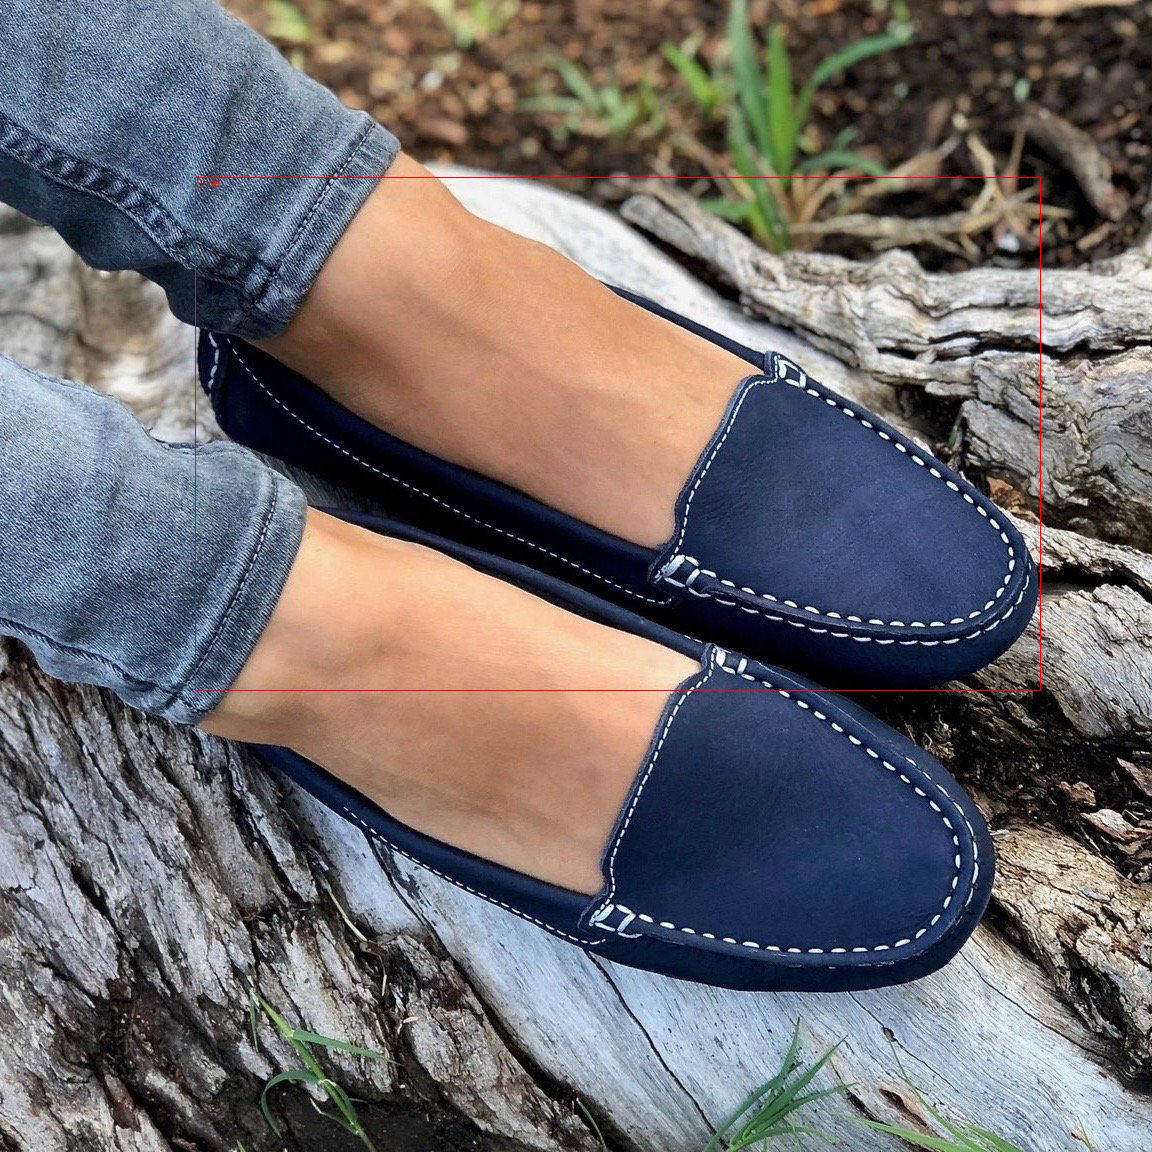

In [29]:
draw_bounding_box(INPUT_SEARCH_IMAGE, boxes, labels)

### 4.3 Extract and save labelled objects

In [30]:
# Same code as above, only now to save each labeled object as a separate image

# Import required libraries to draw bounding box on image
from PIL import Image, ImageDraw, ImageFont

# Function to extract and save each labelled object as a separate image
def extract_objects(image_path, boxes, labels):
    # Load the image
    image = Image.open(image_path)
    
    # Convert RGBA to RGB if necessary
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    
    draw = ImageDraw.Draw(image)
    
    # Font for the label
    try:
        font = ImageFont.truetype("arial.ttf", 15)
    except IOError:
        font = ImageFont.load_default()

    # Counter for unique filenames
    crop_count = 1 
    
    # Draw bounding boxes around specific label of interest (ex. shoe)
    for box, label in zip(boxes, labels):
        if label not in "Shoe":
            continue
    
        # Box coordinates
        left = int(image.width * box['Left'])
        top = int(image.height * box['Top'])
        right = left + int(image.width * box['Width'])
        bottom = top + int(image.height * box['Height'])
    
        # Crop the image to the bounding box
        cropped_image = image.crop((left, top, right, bottom))
    
        # Draw label on the cropped image
        draw = ImageDraw.Draw(cropped_image)
    
        # File name for the output
        file_name = f"extract_{crop_count}.jpg"
        # Save extracted object image locally
        cropped_image.save(file_name)
        print(f"Saved extracted object image: {file_name}")
        crop_count += 1
    


In [31]:
extract_objects(INPUT_SEARCH_IMAGE, boxes, labels)

Saved extracted object image: extract_1.jpg


## 5. Embed extracted object image

Now that we have extracted the object of interest from the input image, we can embed the image in a vector representation so it can be queried against the OpenSearch collection index

In [32]:
# Open the extracted object image file in binary mode
# The extracted images will be saved as extract_1.jpg, extract_2.jpg, etc.
with open("extract_1.jpg", "rb") as image_file:
    base64_encoded_image = base64.b64encode(image_file.read()).decode('utf-8')

# Embed the extracted object image
object_embedding = create_image_embedding(image=base64_encoded_image)

# Print the first few numbers of the embedding followed by ...
print(f"Image embedding: {object_embedding[:5]} ...")

Image embedding: [0.038584117, 0.01647105, -0.044226136, -0.024752075, -0.008235525] ...


## 6. Perform reverse image search

With the embedded extracted object image, we can now query against the vector index using a K-NN search

### 6.1 Perform a K-NN search on index

In [36]:
# Initialize endpoint name constant


# Initialize and authenticate with the OpenSearch client
credentials = boto3.Session().get_credentials()
auth = AWS4Auth(credentials.access_key, credentials.secret_key, REGION, 'aoss', session_token=credentials.token)
client = OpenSearch(
    hosts=[{'host': HOST, 'port': 443}],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection,
    pool_maxsize=300
)

# Define number of images to search and retrieve
K_SEARCHES = 3

# Define search configuration body for K-NN 
body = {
        "size": K_SEARCHES,
        "_source": {
            "exclude": [VECTOR_NAME],
        },
        "query": {
            "knn": {
                VECTOR_NAME : {
                    "vector": object_embedding,
                    "k": K_SEARCHES,
                }
            }
        },
        "_source": True,
        "fields": [VECTOR_MAPPING],
    }

# Invoke OpenSearch to search through index with K-NN configurations
knn_response = client.search(index=INDEX_NAME, body=body)
result = []
scores_tracked = set()  # Set to keep track of already retrieved images and their scores

# Loop through response to print the closest matching results
for hit in knn_response["hits"]["hits"]:
    id_ = hit["_id"]
    score = hit["_score"]
    item_id_ = hit["_source"][VECTOR_MAPPING]

    # Check if score has already been tracked, if not, add it to final result
    if score not in scores_tracked:
        final_item = [item_id_, score]
        result.append(final_item)
        scores_tracked.add(score)  # Log score as tracked already

# Print Top K closest matches
print(f"Top {K_SEARCHES} closest embeddings and associated scores: {result}")

Top 3 closest embeddings and associated scores: [['image34.jpeg', 0.7366825], ['image41.jpeg', 0.6427732]]


### 6.2 Display similar images from S3

File Name: image34.jpeg
Score: 0.7366825


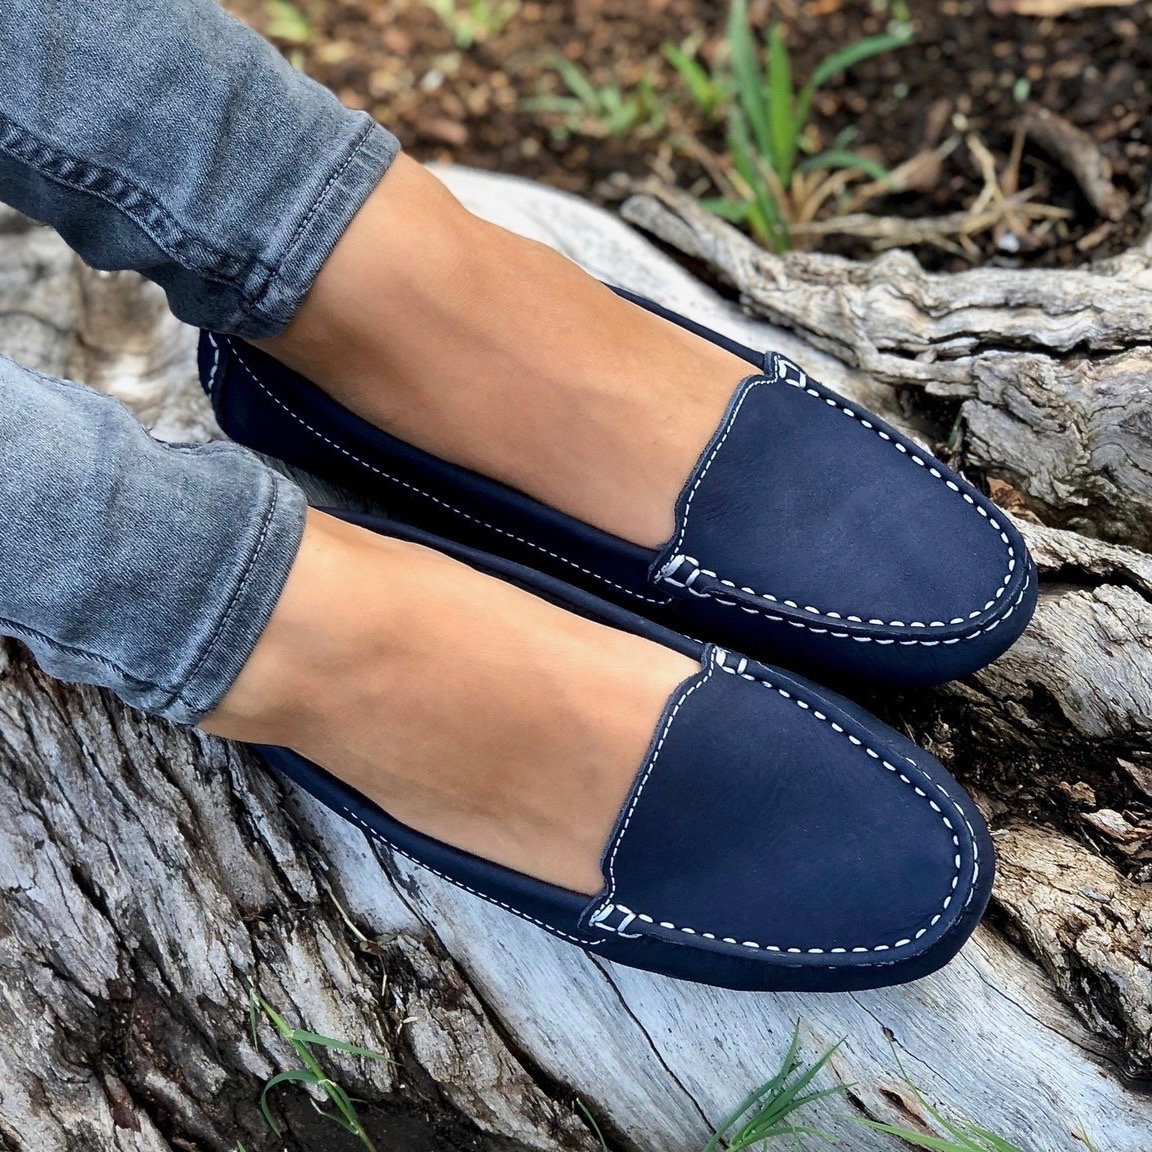


File Name: image41.jpeg
Score: 0.6427732


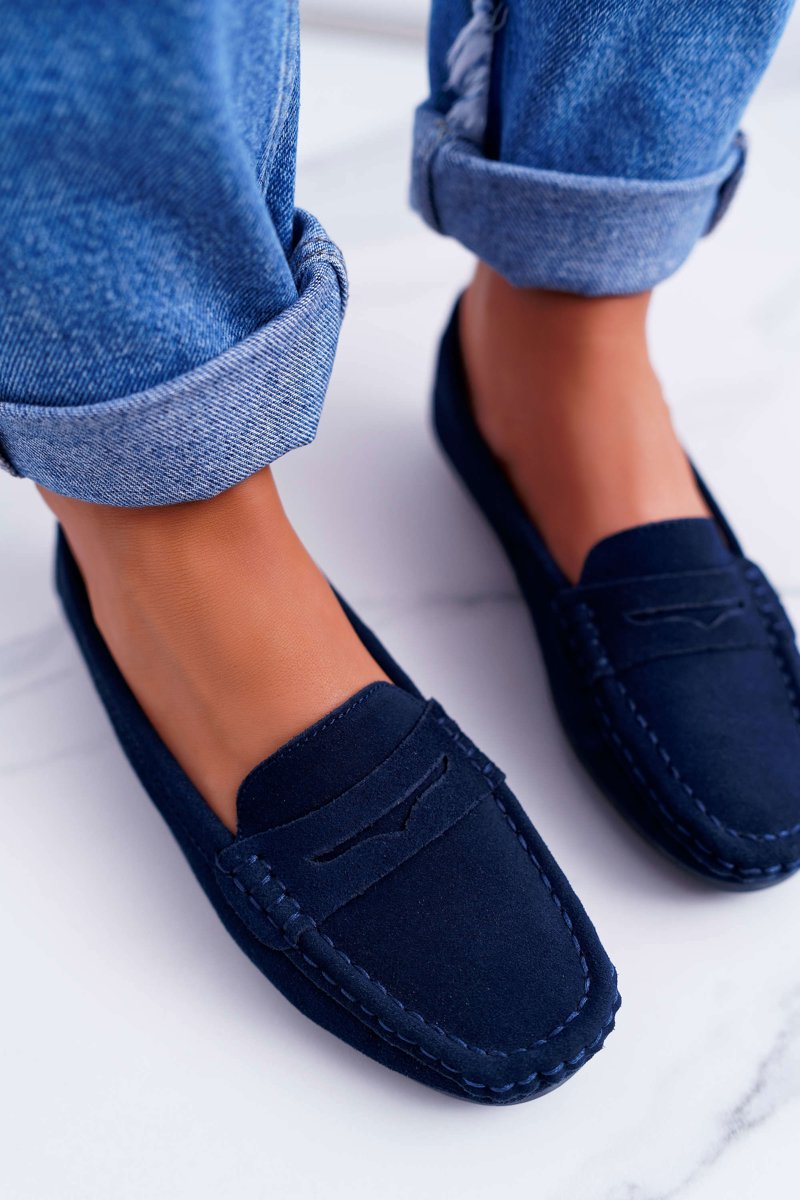

In [37]:
import os

# Function to display image
def display_image(image_path):
    image = Image.open(image_path)
    image.show()

# List of image file names from the K-NN search
image_files = result

# Create a local directory to store downloaded images
download_dir = 'RESULTS'

# Create directory if not exists
os.makedirs(download_dir, exist_ok=True)

# Download and display each image that matches image query
for file_name in image_files:
    print("File Name: " + file_name[0])
    print("Score: " + str(file_name[1]))
    local_path = os.path.join(download_dir, file_name[0])
    # Ensure to add in necessary prefix before file name if files are in subdirectories in the bucket
    # ex. s3.download_file(BUCKET_NAME, "Shoes/Sneakers and Athletic Shoes/Nike/"+file_name[0], local_path)
    s3.download_file(BUCKET_NAME, file_name[0], local_path)
    # Open downloaded image and display it
    display_image(local_path)
    print()

## 7. Clean up

To remove resources after usage, perform the following steps in your AWS Management console:

Empty and delete the S3 bucket. Delete the index in the OpenSearch Serverless collection. Delete the OpenSearch Serverless collection. Delete SageMaker Studio user profile and domain.